# Семинар 4. Метод максимального правдоподобия для построения функции потерь и продвинутые алгоритмы градиентного спуска
**Внимание!** В этом семинаре для содержательной части кода разрешается использовать только библиотеку `numpy`. Решения с использованием других библиотек не будут засчитаны.


## Задача 4.1 [max = 20 баллов]

Пусть нам задан тренировочный датасет $(X_i, y_i)$ и ожидается, что метки $y$ являются нормально распределенными случайными величинами с параметрами $\mu$ и $\sigma^2$. Мы хотим обучить так называемую **[гетероcкедастичную](https://ru.wikipedia.org/wiki/%D0%93%D0%B5%D1%82%D0%B5%D1%80%D0%BE%D1%81%D0%BA%D0%B5%D0%B4%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%BE%D1%81%D1%82%D1%8C)** модель. А именно, при помощи модели с двумя выходами мы хотим оценить для каждого наблюдения величину $\mu_i=F_1(X_i,\,p)$ и величину $\sigma^2_i=F_2(X_i, p)$.

[3 балла] С помощью метода максимального правдоподобия постройте аналитически функцию потерь $L[p]$

[2 балла] Выразите аналитически градиент полученной в предыдущем пункте функции потерь по параметрам $p$ через градиенты $\operatorname{grad}_p [F_{1}]$ и $\operatorname{grad}_p [F_{2}]$

[5 баллов] Реализуйте гетероскедастичную модель в виде нейронной сети с произвольным числом входов, двумя выходами и одним скрытым слоем. Для этого дополните предложенный ниже класс `HeteroscedasticModel` (можно пользоваться фрагментами кода из третьего семинара).

Полностью векторизуйте решение, выполните проверки некорректных входов. Предусмотрите возможность подачи списка из двух произвольных функций активации, каждая из которых имеет методы `__call__` и `derivative`, — одна будет встроена во все скрытые элементы, другая — в выходной слой. При дальнейшей работе с моделью не забудьте учесть, что дисперсия случайной величины не может быть отрицательной. Покажите примеры работы модели на случайно сгенерированных данных.

```python
import numpy as np

class HeteroscedasticModel:
    def __init__(self, input_size:int, hidden_size:int, activations:list, random_seed=None):

        assert isinstance(input_size, int)
        assert input_size > 0
        assert isinstance(hidden_size, int)
        assert hidden_size > 0
        # TO-DO: добавьте дополнительные проверки

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.activations = activations
        # TO-DO: инициализируйте параметры нужного размера случайным образом


    def __call__(self, X:np.ndarray)->np.ndarray:
        return self.forward(X)

    def forward(self, X:np.ndarray)->np.ndarray:
        """
        Params
        ------
        X : np.ndarray of shape (n_samples, self.input_size)

        Returns
        -------
        np.ndarray of shape (n_samples, 2)
        """
        # TO-DO: проверьте корректность входных данных
        # TO-DO: вычислите и верните выходные значения

    def backward(self, X:np.ndarray)->tuple[np.ndarray, np.ndarray]:
        """
        Params
        ------
        X : np.ndarray of shape (n_samples, self.input_size)

        Returns
        -------
        tuple :
            np.ndarray of shape (n_samples, 2, self.input_size + 1, self.hidden_size)
            np.ndarray of shape (n_samples, 2, self.hidden_size + 1)
        """
        # TO-DO: проверьте корректность входных данных
        # TO-DO: вычислите и верните градиент выходных значений по параметрам

```

 **Внимание: оставшиеся пункты данной задачи оцениваются только при условии верного выполнения всех трех вышеперечисленных**

In [ ]:
import numpy as np

class Sigmoid:
    def __init__(self): pass
    def __call__(self, x: np.ndarray) -> np.ndarray:
        if not isinstance(x, np.ndarray):
            raise TypeError("Input must be a numpy array")
        return 1 / (1 + np.exp(-x))
    def derivative(self, x: np.ndarray) -> np.ndarray:
        if not isinstance(x, np.ndarray):
            raise TypeError("Input must be a numpy array")
        s = self.__call__(x)
        return s * (1 - s)

class ReLU:
    def __init__(self): pass
    def __call__(self, x: np.ndarray) -> np.ndarray:
        if not isinstance(x, np.ndarray):
            raise TypeError("Input must be a numpy array")
        return np.maximum(0, x)
    def derivative(self, x: np.ndarray) -> np.ndarray:
        if not isinstance(x, np.ndarray):
            raise TypeError("Input must be a numpy array")
        # правосторонний предел в 0 -> 1 (как ты и задал)
        grad = np.where(x > 0, 1, 0)
        grad = np.where(x == 0, 1, grad)
        return grad

class Identity:
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return x
    def derivative(self, x: np.ndarray) -> np.ndarray:
        return np.ones_like(x)

def softplus(x: np.ndarray) -> np.ndarray:
    return np.maximum(x, 0) + np.log1p(np.exp(-np.abs(x)))
def softplus_prime(x: np.ndarray) -> np.ndarray:
    out = np.empty_like(x)
    pos = (x >= 0)
    out[pos] = 1.0/(1.0 + np.exp(-x[pos]))
    ex = np.exp(x[~pos])
    out[~pos] = ex/(1.0 + ex)
    return out

class HeteroscedasticModel:
    def __init__(self, input_size:int, hidden_size:int, activations:list, random_seed=None, eps:float=1e-6):
        assert isinstance(input_size, int) and input_size>0
        assert isinstance(hidden_size, int) and hidden_size>0
        assert isinstance(activations, (list, tuple)) and len(activations)==2
        assert hasattr(activations[0], "__call__") and hasattr(activations[0], "derivative")
        assert hasattr(activations[1], "__call__") and hasattr(activations[1], "derivative")
        self.input_size, self.hidden_size = input_size, hidden_size
        self.activations = activations
        self.eps = float(eps)
        if random_seed is not None:
            np.random.seed(int(random_seed))
        # Xavier init
        lim1 = np.sqrt(6.0/(input_size + hidden_size))
        self.W1 = np.random.uniform(-lim1, lim1, size=(input_size, hidden_size))
        self.b1 = np.zeros((hidden_size,))
        lim2 = np.sqrt(6.0/(hidden_size + 2))
        self.W2 = np.random.uniform(-lim2, lim2, size=(hidden_size, 2))
        self.b2 = np.zeros((2,))
        self._cache = None

    def _check_X(self, X: np.ndarray):
        if not isinstance(X, np.ndarray):
            raise TypeError("X must be np.ndarray")
        if X.ndim != 2 or X.shape[1] != self.input_size:
            raise ValueError(f"X must be of shape (n_samples, {self.input_size})")

    def forward(self, X: np.ndarray) -> np.ndarray:
        self._check_X(X)
        act_h, act_o = self.activations
        z1 = X @ self.W1 + self.b1
        h  = act_h(z1)
        z2 = h @ self.W2 + self.b2
        o2 = act_o(z2)
        mu_raw  = o2[:,0]
        var_raw = o2[:,1]
        sigma2  = softplus(var_raw) + self.eps
        out = np.empty_like(o2)
        out[:,0] = mu_raw
        out[:,1] = sigma2
        self._cache = {"X":X, "z1":z1, "h":h, "z2":z2, "o2":o2}
        return out

    __call__ = forward

    def backward(self, X: np.ndarray):
        self._check_X(X)
        if (self._cache is None) or (self._cache["X"] is not X):
            self.forward(X)
        act_h, act_o = self.activations
        z1, h, z2, o2 = self._cache["z1"], self._cache["h"], self._cache["z2"], self._cache["o2"]
        n, H, D = X.shape[0], self.hidden_size, self.input_size

        dh_dz1  = act_h.derivative(z1)     # (n,H)
        do2_dz2 = act_o.derivative(z2)     # (n,2)

        dmu_dz2_0 = do2_dz2[:,0]                          # (n,)
        ds2_dz2_1 = do2_dz2[:,1] * softplus_prime(o2[:,1])# (n,)

        gW2 = np.zeros((n,2,H+1), dtype=X.dtype)
        gW2[:,0,:H] = h * dmu_dz2_0[:,None]
        gW2[:,0, H] = dmu_dz2_0
        gW2[:,1,:H] = h * ds2_dz2_1[:,None]
        gW2[:,1, H] = ds2_dz2_1
        
        gW1 = np.zeros((n,2,D+1,H), dtype=X.dtype)
        coeff0 = dh_dz1 * (self.W2[:,0][None,:]) * dmu_dz2_0[:,None]
        coeff1 = dh_dz1 * (self.W2[:,1][None,:]) * ds2_dz2_1[:,None]
        gW1[:,0,:D,:] = X[:,:,None] * coeff0[:,None,:]
        gW1[:,0, D,:] = coeff0
        gW1[:,1,:D,:] = X[:,:,None] * coeff1[:,None,:]
        gW1[:,1, D,:] = coeff1
        return gW1, gW2

    @staticmethod
    def gaussian_nll(y: np.ndarray, mu: np.ndarray, sigma2: np.ndarray, eps: float = 1e-12, reduce: str="mean"):
        s2 = np.maximum(sigma2, eps)
        term = 0.5*(np.log(2*np.pi) + np.log(s2) + (y - mu)**2 / s2)
        if reduce=="mean": return np.mean(term)
        if reduce=="sum":  return np.sum(term)
        return term

    @staticmethod
    def nll_grad_wrt_outputs(y: np.ndarray, mu: np.ndarray, sigma2: np.ndarray, eps: float = 1e-12):
        s2  = np.maximum(sigma2, eps)
        inv = 1.0/s2
        dmu = (mu - y)*inv
        ds2 = 0.5*(inv - (y - mu)**2 * inv * inv)
        return dmu, ds2

    def fit(self, X: np.ndarray, y: np.ndarray, learning_rate: float, maxiter: int, tolerance: float,
            grad_clip: float | None = 5.0):
        self._check_X(X)
        if not (isinstance(y, np.ndarray) and y.ndim==1 and y.shape[0]==X.shape[0]):
            raise ValueError("y must be shape (n_samples,)")

        step = 0
        pred = self.forward(X)
        mu, s2 = pred[:,0], pred[:,1]
        loss = self.gaussian_nll(y, mu, s2, eps=self.eps, reduce="mean")

        while loss > tolerance:
            gW1_y, gW2_y = self.backward(X)                # (n,2,D+1,H), (n,2,H+1)
            dmu, ds2 = self.nll_grad_wrt_outputs(y, mu, s2, eps=self.eps)
            G = np.stack([dmu, ds2], axis=1)               # (n,2)

            Gb = (G[:,:,None,None] * gW1_y).sum(axis=(0,1))# (D+1,H)
            gW1 = Gb[:self.input_size,:]
            gb1 = Gb[self.input_size,:]

            gW2 = np.zeros_like(self.W2)
            gb2 = np.zeros_like(self.b2)
            for k in range(2):
                acc = (G[:,k][:,None] * gW2_y[:,k,:]).sum(axis=0)  # (H+1,)
                gW2[:,k] = acc[:self.hidden_size]
                gb2[k]   = acc[self.hidden_size]
            if grad_clip is not None and grad_clip > 0:
                def clip_(arr):
                    nrm = np.linalg.norm(arr.ravel()) + 1e-12
                    if nrm > grad_clip:
                        arr *= (grad_clip / nrm)
                clip_(gW1); clip_(gb1); clip_(gW2); clip_(gb2)

            self.W1 -= learning_rate * gW1
            self.b1 -= learning_rate * gb1
            self.W2 -= learning_rate * gW2
            self.b2 -= learning_rate * gb2

            step += 1
            if (step > maxiter > 0): break
            pred = self.forward(X)
            mu, s2 = pred[:,0], pred[:,1]
            loss = self.gaussian_nll(y, mu, s2, eps=self.eps, reduce="mean")
        return self
    
# случайные данные
n_samples = 5
input_size = 4
X = np.random.normal(size=(n_samples, input_size))

model = HeteroscedasticModel(
    input_size=X.shape[1],
    hidden_size=64,
    activations=[ReLU(), Identity()], 
    random_seed=42,
    eps=1e-6
)

out = model.forward(X)
print("выходы (mu, sigma2):")
print(out)
assert out.shape == (n_samples, 2)

gr_in_h, gr_h_out = model.backward(X)
print("grads_in_h shape:", gr_in_h.shape) 
print("grads_h_out shape:", gr_h_out.shape) 


выходы (mu, sigma2):
[[-0.23535752  0.61867949]
 [ 0.10598978  0.72387738]
 [-0.04610636  0.65548852]
 [ 0.02491919  0.67850271]
 [-0.07918317  0.70343961]]
grads_in_h shape: (5, 2, 5, 64)
grads_h_out shape: (5, 2, 65)


[5 баллов] На основе ваших аналитических результатов дополните класс `HeteroscedasticModel` методом `fit`, в котором веса модели оптимизируются по алгоритму граидентного спуска, по предложенному ниже образцу. Можно использовать фрагменты вашего кода из третьего семинара. Продемонстрируйте работу метода на примере случайно сгенерированного датасета.

```python
class HeteroscedasticModel:
# ...
    def fit(self,
            X:np.ndarray, y:np.ndarray,
            learning_rate:float,
            maxiter:int,
            tolerance:float,
        ):
        """
        Params
        ------
        X : np.ndarray of shape (n_samples, self.input_size)
        y : np.ndarray of shape (n_samples,)
        learning_rate : float
            positive constant controlling gradient descent step
        maxiter : int
            maximum number of gradient descent iterations
        tolerance : float
            maximum acceptable loss function value for early stopping

        Returns
        -------
        self : HeteroscedasticModel
            fitted model instance
        """
        # TO-DO: сделайте проверку корректности входных данных
        
        step = 0
        pred = # TO-DO: рассчитайте начальные выходы модели с использованием метода forward
        loss = # TO-DO: расчитайте текущее значение функции потерь

        while loss > tolerance:

            print("step: %d \t loss: %.3lg" % (step, loss))

            # TO-DO: расчитайте градиент функции потерь по параметрам с использованием метода backward

            # TO-DO: обновите параметры модели с учетом рассчитанного выше градиента и коэффициента learning_rate

            step += 1
            pred = # TO-DO: рассчитайте новые выходы модели с использованием метода forward
            loss = # TO-DO: расчитайте текущее значение функции потерь
            
            if (step > maxiter > 0):
                break

        print("training finished after %d iterations, loss=%.3lg achieved" % (step, loss))

        return self
```

[5 баллов] Обучите модель на предложенном датасете. Для загрузки датасета используйте код ниже либо получите датасет напрямую по [ссылке](https://drive.google.com/file/d/1imwrPiTI9025FPr_jDKgBtLG_9uYpmDF/view?usp=sharing)

```python
import numpy as np

# загрузка данных
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1imwrPiTI9025FPr_jDKgBtLG_9uYpmDF' -O dataset.npz

dataset = np.load('dataset.npz', allow_pickle=True)
X_train, y_train, X_test, y_test = dataset['X_train'], dataset['y_train'], dataset['X_test'], dataset['y_test']
```


Количество скрытых элементов и прочие необходимые параметры подберите самостоятельно.

Визуализируйте предсказание модели на графике в виде линии, отвечающей значению $\mu$ (см. `matplotlib.pyplot.plot`), и полосы вокруг нее (см. `matplotlib.pyplot.fill_between`), выделяющей регион $\mu\pm 2\sigma$, что примерно соответствует 95\%-ному доверительному интервалу предсказания $y$. На тот же график нанесите точки тренировочного и тестового фрагментов датасета. Выберите адекватный диапазон осей, подпишите оси и элементы графика.

На отдельном графике изобразите две кривые: $\mu(x)$ и $\sigma(x)$.


In [116]:

#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1imwrPiTI9025FPr_jDKgBtLG_9uYpmDF' -O dataset.npz

dataset = np.load('heteroscedastic-dataset.npz', allow_pickle=True)
X_train, y_train = dataset['X_train'], dataset['y_train']
X_test,  y_test  = dataset['X_test'],  dataset['y_test']

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)

model = HeteroscedasticModel(
    input_size=X_train.shape[1],
    hidden_size=64,
    activations=[ReLU(), Identity()], 
    random_seed=42,
    eps=1e-6
)

model.fit(
    X=X_train,
    y=y_train,
    learning_rate=1e-3, 
    maxiter=2000,
    tolerance=1e-4,  
    grad_clip=5.0
)

X_train: (5000, 1) y_train: (5000,)
X_test : (5000, 1) y_test : (5000,)


Train NLL: 0.9224 | Test NLL: 0.8948


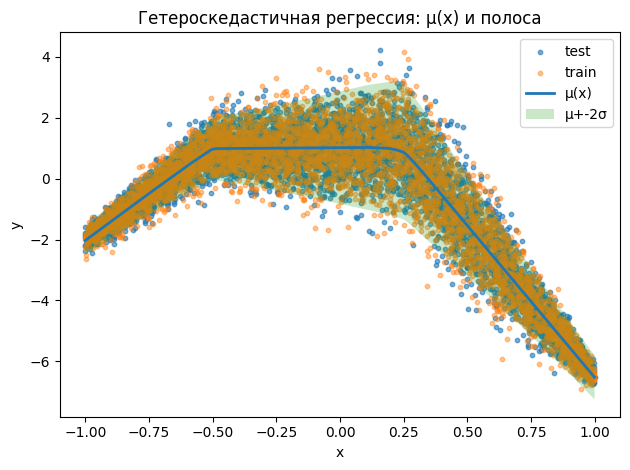

In [117]:
import matplotlib.pyplot as plt

pred_tr = model.forward(X_train)
pred_te = model.forward(X_test)
train_nll = HeteroscedasticModel.gaussian_nll(y_train, pred_tr[:,0], pred_tr[:,1], reduce="mean")
test_nll  = HeteroscedasticModel.gaussian_nll(y_test,  pred_te[:,0], pred_te[:,1],  reduce="mean")
print(f"Train NLL: {train_nll:.4f} | Test NLL: {test_nll:.4f}")

def _prep_axis_and_sort(X: np.ndarray):
    x = X[:,0].reshape(-1)
    order = np.argsort(x)
    return x[order], order

x_grid, order = _prep_axis_and_sort(X_test if X_test.shape[0] else X_train)
grid_sorted = (X_test if X_test.shape[0] else X_train)[order]
pred_grid   = model.forward(grid_sorted)
mu_grid     = pred_grid[:,0]
sigma_grid  = np.sqrt(pred_grid[:,1])
lower_band  = mu_grid - 2.0*sigma_grid
upper_band  = mu_grid + 2.0*sigma_grid

x_train = X_train[:,0]; x_test = X_test[:,0]

plt.figure()
plt.scatter(x_test,  y_test,  s=10, alpha=0.6, label="test")
plt.scatter(x_train, y_train, s=10, alpha=0.45, label="train")
plt.plot(x_grid, mu_grid, linewidth=2.0, label="μ(x)")
plt.fill_between(x_grid, lower_band, upper_band, alpha=0.25, label="μ+-2σ")
plt.xlabel("x"); plt.ylabel("y")
plt.title("Гетероскедастичная регрессия: μ(x) и полоса")
plt.legend(); plt.tight_layout(); plt.show()

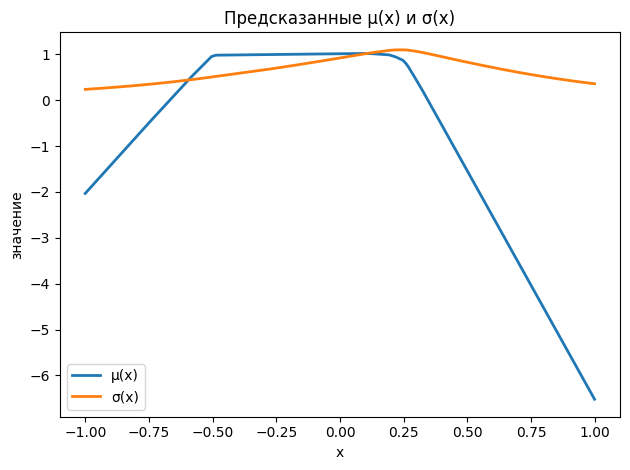

In [118]:
plt.figure()
plt.plot(x_grid, mu_grid, linewidth=2.0, label="μ(x)")
plt.plot(x_grid, sigma_grid, linewidth=2.0, label="σ(x)")
plt.xlabel("x"); plt.ylabel("значение")
plt.title("Предсказанные μ(x) и σ(x)")
plt.legend(); plt.tight_layout(); plt.show()

## Задача 4.2 [max = 10 баллов]

Бывает так, что изучаемая нами величина является циклической: разные значения с некоторым периодом оказываются тождественны. Это может несколько усложнять анализ. Например, это справедливо для угловых переменных: углы, отличающиеся на кратную $2\pi$ радианам величину, тождественны.

В этой задаче вам предлагается поработать с угловой переменной $y$, которая подчиняется [распределению фон Мизеса](https://en.wikipedia.org/wiki/Von_Mises_distribution):
$$f(y\;|\;\mu,\;\kappa) = N(\kappa)^{-1}\cdot \exp[\kappa\cos(y-\mu)],$$
где нормировочный множитель $N$ равен:
$$N(\kappa)=\int\limits_{0}^{2\pi}\exp[\kappa \cos (t)]\,{\rm d}t.$$


[2 балла] Изобразите схематично (в тетради или с помощью кода) заданную плотность распределения. Как она меняется с изменением $\mu$? с изменением $\kappa$?

[4 балла] Считая $\kappa$ постоянной и неизвестной, получите аналитически оценку максимального правдоподобия для $\mu$.

[4 баллов] **Внимание: данный пункт оценивается только при верном выполнении двух предыдущих**

В [файле](https://drive.google.com/file/d/1N0qrgok_dv2sy2Kt6Yh4AHR4hoxhiPW-/view?usp=share_link) находятся измеренные значения (в радианах) некоторого угла. Пользуясь вашими результатами, оцените оптимальное $\mu$ для этого датасета (всю выборку считайте обучающей). Изобразите на одном графике гистограмму распределения выборки и плотности вероятности фон Мизеса с наилучшим параметром $\mu$ при $\kappa=0.5,\;1.0,\;2.0$. Оцените визуально наиболее подходящее значение $\kappa$ из числа предложенных

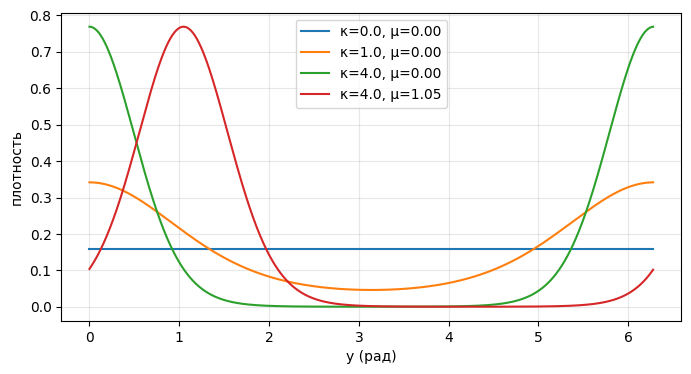

In [119]:
import numpy as np, matplotlib.pyplot as plt

ys = np.linspace(0, 2*np.pi, 1000, endpoint=False)
def vm_pdf(y, mu, k):
    return np.exp(k*np.cos(y-mu)) / (2*np.pi*np.i0(k))  # i0 — Bessel I0 в numpy

plt.figure(figsize=(8,4))
for k, mu, ls in [(0.0, 0.0, '-'), (1.0, 0.0, '--'), (4.0, 0.0, '-.'), (4.0, np.pi/3, ':')]:
    plt.plot(ys, vm_pdf(ys, mu, k), label=f'κ={k}, μ={mu:.2f}')
plt.xlabel('y (рад)'); plt.ylabel('плотность'); plt.legend(); plt.grid(True, alpha=.3); plt.show()


Прочитано 10000 наблюдений, диапазон [-9.424, 9.425]
Оценка μ_MLE = 0.7799 радиан


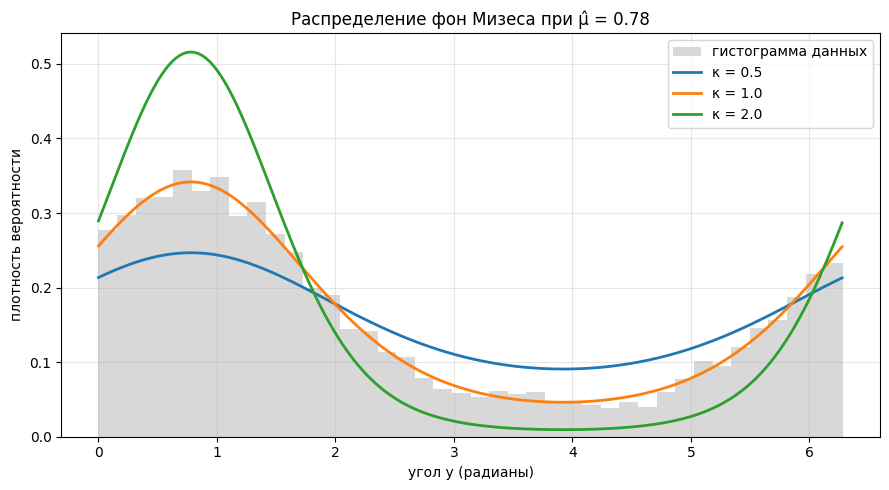

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# === загрузка файла с угловыми данными ===
# (замените имя на актуальное, если файл уже загружен в среду)
data = np.loadtxt("vonMisesRandomVariable.txt")  # файл должен содержать углы в радианах, по строкам
y = np.asarray(data, dtype=np.float64)

print(f"Прочитано {len(y)} наблюдений, диапазон [{y.min():.3f}, {y.max():.3f}]")

# === оценка μ_MLE для фиксированной κ ===
C = np.sum(np.cos(y))
S = np.sum(np.sin(y))
mu_hat = np.arctan2(S, C)  # оценка максимального правдоподобия μ
mu_hat = np.mod(mu_hat, 2*np.pi)

print(f"Оценка μ_MLE = {mu_hat:.4f} радиан")

# === определим нормировочный множитель N(κ) ===
# N(κ) = 2π I0(κ); numpy.i0 — модифиц. функция Бесселя I0
def von_mises_pdf(y, mu, kappa):
    return np.exp(kappa * np.cos(y - mu)) / (2 * np.pi * np.i0(kappa))

# === построение ===
ys = np.linspace(0, 2*np.pi, 1000, endpoint=False)
kappas = [0.5, 1.0, 2.0]

plt.figure(figsize=(9,5))

# гистограмма по углам
plt.hist(y % (2*np.pi), bins=40, density=True, alpha=0.3, color="gray", label="гистограмма данных")

# кривые фон Мизеса
for k in kappas:
    plt.plot(ys, von_mises_pdf(ys, mu_hat, k), lw=2, label=f"κ = {k}")

plt.xlabel("угол y (радианы)")
plt.ylabel("плотность вероятности")
plt.title(f"Распределение фон Мизеса при μ̂ = {mu_hat:.2f}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Задача 4.3 [max = 10 баллов]
**Внимание: данная задача оцениваются только при условии верного выполнения задачи 4.1**

Модифицируйте метод `fit` класса `HeteroscedasticModel`, который вы реализовали в первой задаче. А именно:

[5 баллов] Реализуйте стохастический градиентный спуск, то есть:
- согласованно перемешайте `X` и `y`
- разбейте их на батчи (число батчей должно стать новым дополнительным параметром метода `fit`)
- обновляйте веса согласно градиенту функции потерь на отдельных батчах, проходя шаг за шагом по всем батчам
- в конце эпохи проверьте условия остановки, и если они не выполняются, снова согласованно перемешайте `X` и `y` и т.д.

Зафиксируйте число батчей, равное 50. Проверьте, что новый алгоритм обучается не хуже первоначального на предложенных данных. Изобразите на одном графике зависимость средней по датасету функции потерь от номера эпохи для стандартного и стохастического градиентного спуска.

[5 баллов] Реализуйте динамическую скорость обучения: добавьте возможность пользователю передавать в метод `fit` функцию `lr_scheduler`, которая будет сопоставлять текущему номеру эпохи текущую скорость обучения. Сравните стохастический градиентный спуск и стохастический градиентный спуск с `lr_scheduler`, в которой чередуются периоды плавного затухания скорости обучения и резкие всплески. Изобразите на одном графике зависимость средней по датасету функции потерь от номера эпохи для стохастического градиентного спуска с и без выбора `lr_scheduler`.



In [121]:
import numpy as np

class HeteroscedasticModel:
    def __init__(self, input_size:int, hidden_size:int, activations:list, random_seed=None):
        if not (isinstance(input_size, int) and input_size > 0):
            raise ValueError("input_size must be positive int.")
        if not (isinstance(hidden_size, int) and hidden_size > 0):
            raise ValueError("hidden_size must be positive int.")
        if not (isinstance(activations, (list, tuple)) and len(activations) == 2):
            raise ValueError("activations must be [hidden_act, out_act].")
        hidden_act, out_act = activations
        if hidden_act is not None and not (hasattr(hidden_act, "__call__") and hasattr(hidden_act, "derivative")):
            raise TypeError("hidden activation must have __call__ and derivative.")
        if out_act is not None and not (hasattr(out_act, "__call__") and hasattr(out_act, "derivative")):
            raise TypeError("output activation must have __call__ and derivative.")
        if random_seed is not None and not isinstance(random_seed, (int, np.integer)):
            raise TypeError("random_seed must be int or None.")

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.activations = activations

        rng = np.random.default_rng(random_seed)
        self.W_in_h = rng.normal(size=(input_size, hidden_size)).astype(np.float64)
        self.b_h    = rng.normal(size=(hidden_size,)).astype(np.float64)
        self.W_h_out = rng.normal(size=(hidden_size, 2)).astype(np.float64)
        self.b_out   = rng.normal(size=(2,)).astype(np.float64)

    @staticmethod
    def _check_X(X, input_size):
        X = np.asarray(X)
        if X.ndim != 2:
            raise ValueError("X must be 2D (n_samples, input_size).")
        if X.shape[1] != input_size:
            raise ValueError(f"X.shape[1] must be {input_size}.")
        if X.dtype.kind not in "iufc":
            raise TypeError("X must be numeric.")
        return X.astype(np.float64, copy=False)

    @staticmethod
    def _positive_var(raw_v, method="exp"):
        if method == "exp":
            return np.exp(raw_v)
        elif method == "softplus":
            return np.log1p(np.exp(-np.abs(raw_v))) + np.maximum(raw_v, 0)
        else:
            raise ValueError("unknown method")

    def forward(self, X:np.ndarray)->np.ndarray:
        X = self._check_X(X, self.input_size)
        hidden_act, out_act = self.activations

        Z = X @ self.W_in_h + self.b_h  # (n,m)
        if hidden_act is None:
            H = Z
        else:
            H = hidden_act(Z)
        H = np.asarray(H, dtype=np.float64)

        Y_lin = H @ self.W_h_out + self.b_out  # (n,2)
        if out_act is None:
            Y = Y_lin
        else:
            Y = out_act(Y_lin)
        Y = np.asarray(Y, dtype=np.float64)

        mu = Y[:, 0]
        var_raw = Y[:, 1]
        sigma2 = self._positive_var(var_raw, method="exp")

        return np.stack([mu, sigma2], axis=1)

    def backward(self, X:np.ndarray):
        """
        Возвращает:
          grads_in_h : (n, 2, d+1, m)
          grads_h_out: (n, 2, m+1)
        """
        X = self._check_X(X, self.input_size)
        n, d = X.shape
        m = self.hidden_size
        hidden_act, out_act = self.activations

        # forward с промежуточными
        Z = X @ self.W_in_h + self.b_h              # (n,m)
        if hidden_act is None:
            H = Z
            dH_dZ = np.ones_like(Z)
        else:
            H = hidden_act(Z)
            dH_dZ = hidden_act.derivative(Z)
        H = np.asarray(H, dtype=np.float64)
        dH_dZ = np.asarray(dH_dZ, dtype=np.float64)

        Y_lin = H @ self.W_h_out + self.b_out       # (n,2)
        if out_act is None:
            Y = Y_lin
            dY_dYlin = np.ones_like(Y_lin)
        else:
            Y = out_act(Y_lin)
            dY_dYlin = out_act.derivative(Y_lin)
        Y = np.asarray(Y, dtype=np.float64)
        dY_dYlin = np.asarray(dY_dYlin, dtype=np.float64)

        # разбор по двум выходам
        y_lin_mu = Y_lin[:, 0]
        y_lin_var = Y_lin[:, 1]

        sigma2 = self._positive_var(y_lin_var, method="exp")  # (n,)
        dvar_d_yvarlin = sigma2  # d exp / d arg

        # верхний слой
        dF1_dYlin0 = dY_dYlin[:, 0]              # (n,)
        dF1_dW_h_out = dF1_dYlin0[:, None] * H   # (n,m)
        dF1_db_out   = dF1_dYlin0                # (n,)

        dF2_dYlin1 = dvar_d_yvarlin * dY_dYlin[:, 1]  # (n,)
        dF2_dW_h_out = dF2_dYlin1[:, None] * H        # (n,m)
        dF2_db_out   = dF2_dYlin1                      # (n,)

        # нижний слой
        w_mu  = self.W_h_out[:, 0]  # (m,)
        w_var = self.W_h_out[:, 1]  # (m,)

        dF1_dH = dF1_dYlin0[:, None] * w_mu[None, :]      # (n,m)
        dF2_dH = dF2_dYlin1[:, None] * w_var[None, :]     # (n,m)

        dF1_dW_in_h = dF1_dH[:, None, :] * dH_dZ[:, None, :] * X[:, :, None]  # (n,d,m)
        dF2_dW_in_h = dF2_dH[:, None, :] * dH_dZ[:, None, :] * X[:, :, None]  # (n,d,m)

        dF1_db_h = dF1_dH * dH_dZ    # (n,m)
        dF2_db_h = dF2_dH * dH_dZ    # (n,m)

        grads_in_h = np.zeros((n, 2, d+1, m), dtype=np.float64)
        grads_in_h[:, 0, :d, :] = dF1_dW_in_h
        grads_in_h[:, 0, d:d+1, :] = dF1_db_h[:, None, :]
        grads_in_h[:, 1, :d, :] = dF2_dW_in_h
        grads_in_h[:, 1, d:d+1, :] = dF2_db_h[:, None, :]

        grads_h_out = np.zeros((n, 2, m+1), dtype=np.float64)
        grads_h_out[:, 0, :m] = dF1_dW_h_out
        grads_h_out[:, 0, m]  = dF1_db_out
        grads_h_out[:, 1, :m] = dF2_dW_h_out
        grads_h_out[:, 1, m]  = dF2_db_out

        return grads_in_h, grads_h_out

    @staticmethod
    def _loss_mean(mu, sigma2, y):
        # средняя по датасету ММП-потеря (без константы 0.5*log(2π))
        # L̄ = (1/2n) * sum_i [ log σ² + (y-μ)² / σ² ]
        n = y.shape[0]
        return 0.5 * np.sum(np.log(sigma2) + ((y - mu) ** 2) / sigma2) / n

    @staticmethod
    def _dL_douts(mu, sigma2, y):
        # производные средней потери по выходам (размерности (n,))
        # для средней потери коэффициент 1/n входит сюда
        n = y.shape[0]
        dL_dmu = ((mu - y) / sigma2) / n
        dL_dsigma2 = 0.5 * (1.0 / sigma2 - ((y - mu) ** 2) / (sigma2 ** 2)) / n
        return dL_dmu, dL_dsigma2

    def fit(self,
            X:np.ndarray, y:np.ndarray,
            learning_rate:float=1e-3,
            max_epochs:int=200,
            tolerance:float=1e-3,
            n_batches:int=None,
            lr_scheduler=None,
            verbose:bool=True,
        ):
        
        X = self._check_X(X, self.input_size)
        y = np.asarray(y)
        if y.ndim != 1 or y.shape[0] != X.shape[0]:
            raise ValueError("y must be 1D and match n_samples.")
        if y.dtype.kind not in "iufc":
            raise TypeError("y must be numeric.")
        y = y.astype(np.float64, copy=False)
        if learning_rate <= 0:
            raise ValueError("learning_rate must be > 0.")
        if tolerance <= 0:
            raise ValueError("tolerance must be > 0.")
        if not isinstance(max_epochs, int):
            raise TypeError("max_epochs must be int.")
        if n_batches is not None and (not isinstance(n_batches, int) or n_batches <= 0):
            raise ValueError("n_batches must be positive int or None.")

        n = X.shape[0]
        rng = np.random.default_rng()  # для перемешиваний
        loss_history = []

        # helper: один шаг полного GD по всей выборке
        def _full_batch_step(Xb, yb, lr):
            pred = self.forward(Xb)
            mu, sigma2 = pred[:,0], pred[:,1]
            dL_dmu, dL_dsigma2 = self._dL_douts(mu, sigma2, yb)
            grads_in_h, grads_h_out = self.backward(Xb)

            # аккумулируем градиенты по параметрам (учитываем среднюю потерю, т.е. деление на |batch|)
            g_W_in_h  = np.zeros_like(self.W_in_h)
            g_b_h     = np.zeros_like(self.b_h)
            g_W_h_out = np.zeros_like(self.W_h_out)
            g_b_out   = np.zeros_like(self.b_out)

            # верхний слой
            g_W_h_out[:, 0] += (dL_dmu[:, None]      * grads_h_out[:, 0, :self.hidden_size]).sum(axis=0)
            g_b_out[0]      += (dL_dmu              * grads_h_out[:, 0, self.hidden_size]).sum()
            g_W_h_out[:, 1] += (dL_dsigma2[:, None]  * grads_h_out[:, 1, :self.hidden_size]).sum(axis=0)
            g_b_out[1]      += (dL_dsigma2          * grads_h_out[:, 1, self.hidden_size]).sum()

            # нижний слой
            g_W_in_h += (dL_dmu[:, None, None]       * grads_in_h[:, 0, :self.input_size, :]).sum(axis=0)
            g_b_h    += (dL_dmu[:, None, None]       * grads_in_h[:, 0, self.input_size:self.input_size+1, :]).sum(axis=0).ravel()
            g_W_in_h += (dL_dsigma2[:, None, None]   * grads_in_h[:, 1, :self.input_size, :]).sum(axis=0)
            g_b_h    += (dL_dsigma2[:, None, None]   * grads_in_h[:, 1, self.input_size:self.input_size+1, :]).sum(axis=0).ravel()

            # шаг
            self.W_in_h  -= lr * g_W_in_h
            self.b_h     -= lr * g_b_h
            self.W_h_out -= lr * g_W_h_out
            self.b_out   -= lr * g_b_out

        # --- обучение по эпохам ---
        for epoch in range(max_epochs):
            lr = float(lr_scheduler(epoch)) if lr_scheduler is not None else learning_rate

            if n_batches is None or n_batches <= 1:
                # полный градиентный спуск
                _full_batch_step(X, y, lr)
            else:
                # SGD: перемешивание + разбиение на батчи
                idx = rng.permutation(n)
                Xs, ys = X[idx], y[idx]
                # делим на n_batches (последний батч может быть короче)
                batches = np.array_split(np.arange(n), n_batches)
                for b_idx in batches:
                    if b_idx.size == 0: 
                        continue
                    _full_batch_step(Xs[b_idx], ys[b_idx], lr)

            # оценим среднюю потерю на всей выборке для логгинга/критерия
            pred_full = self.forward(X)
            epoch_loss = self._loss_mean(pred_full[:,0], pred_full[:,1], y)
            loss_history.append(epoch_loss)

            if verbose and (epoch % max(1, max_epochs//10) == 0 or epoch == max_epochs-1):
                print(f"epoch: {epoch:4d}  lr: {lr:.3g}  mean loss: {epoch_loss:.6g}")

            if epoch_loss <= tolerance:
                if verbose:
                    print(f"Early stop at epoch {epoch}, mean loss={epoch_loss:.6g}")
                break

        return loss_history

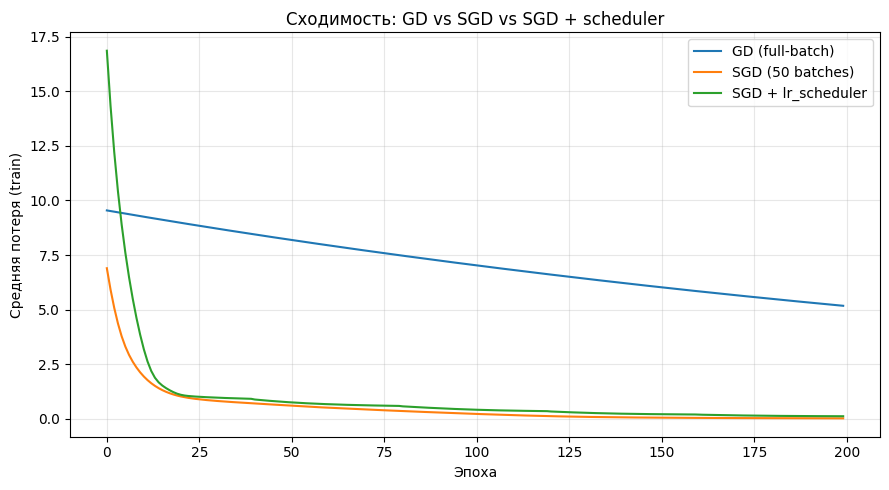

In [122]:
import copy
import matplotlib.pyplot as plt

# вспомогательная функция для «честной» одинаковой инициализации весов
def clone_same_init(base_model):
    m = HeteroscedasticModel(
        input_size=base_model.input_size,
        hidden_size=base_model.hidden_size,
        activations=base_model.activations,
        random_seed=0,  # не важно — сейчас перезапишем веса вручную
    )
    m.W_in_h  = base_model.W_in_h.copy()
    m.b_h     = base_model.b_h.copy()
    m.W_h_out = base_model.W_h_out.copy()
    m.b_out   = base_model.b_out.copy()
    return m

# базовая модель со фиксированной инициализацией
base = HeteroscedasticModel(
    input_size=X_train.shape[1],
    hidden_size=32,
    activations=[ReLU(), None],
    random_seed=42
)

# 1) Полный GD
model_gd = clone_same_init(base)
loss_gd = model_gd.fit(
    X_train, y_train,
    learning_rate=3e-3,
    max_epochs=200,
    tolerance=1e-3,
    n_batches=1,           # полный градиент
    lr_scheduler=None,
    verbose=False
)

# 2) SGD, 50 батчей
model_sgd = clone_same_init(base)
loss_sgd = model_sgd.fit(
    X_train, y_train,
    learning_rate=3e-3,
    max_epochs=200,
    tolerance=1e-3,
    n_batches=50,          # требуемые 50 батчей
    lr_scheduler=None,
    verbose=False
)

# 3) SGD + шедулер (пример: косинусное затухание + периодические всплески)
def cyclical_scheduler(epoch, base_lr=3e-3, period=40, min_mult=0.2, spike_mult=2.5):
    t = epoch % period
    # косинусное затухание в пределах [min_mult, 1]
    cos_part = min_mult + (1 - min_mult) * 0.5 * (1 + np.cos(np.pi * t / (period-1)))
    lr = base_lr * cos_part
    # резкий всплеск в начале цикла
    if t == 0:
        lr *= spike_mult
    return lr

model_sgd_sched = clone_same_init(base)
loss_sgd_sched = model_sgd_sched.fit(
    X_train, y_train,
    learning_rate=3e-3,          # будет переопределяться шедулером
    max_epochs=200,
    tolerance=1e-3,
    n_batches=50,
    lr_scheduler=lambda e: cyclical_scheduler(e, base_lr=3e-3, period=40, min_mult=0.3, spike_mult=2.0),
    verbose=False
)

# --- графики ---
plt.figure(figsize=(9,5))
plt.plot(loss_gd,        label="GD (full-batch)")
plt.plot(loss_sgd,       label="SGD (50 batches)")
plt.plot(loss_sgd_sched, label="SGD + lr_scheduler")
plt.xlabel("Эпоха")
plt.ylabel("Средняя потеря (train)")
plt.title("Сходимость: GD vs SGD vs SGD + scheduler")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Задача 4.4* [max = 10 дополнительных баллов]

Рассмотрим и визуализируем задачу о псевдо-стохастическом градиентный спуске. Представим, что наша **полная** функция потерь $L[p_1, p_2]$ зависит от параметров $p_1$ и $p_2$ следующим образом:

$$L[p_1, p_2] = (p_1^{2}+p_2-11)^{2}+(p_1+p_2^{2}-7)^{2}$$

[2 балла] Изобразите при помощи псевдоцвета высоту графика $L[p_1, p_2]$ в координатах $p_1$ и $p_2$, добавьте поясняющий colorbar (см. `matplotlib.pyplot.contourf` и `matplotlib.pyplot.colorbar`). Ограничьтесь $(p_1,\,p_2) \in [-10, 10] \times [-10, 10]$, для цветовой шкалы выберите такой масштаб, чтобы были видные ключевые особенности графика.

По желанию также изобразите график в 3D

[4 балла] Выведите аналитически градиент для такой $L[p_1, p_2]$ и реализуйте простой градиентный спуск с фиксированной скоростью обучения, отследите траекторию движения в плоскости параметров и нанесите на ранее построенный график для нескольких (3-5) случайных инициализаций и для большого числа итераций.

[4 балла] Вообразим теперь, что при переходе к стохастическому градиентному спуску в каждом батче мы будем иметь функцию потерь вида:


$$L[p_1, p_2] = \left[(1+\epsilon_{11})p_1^{2}+(1+\epsilon_{21})p_2-(1+\epsilon_{01})11\right]^{2}+\left[(1+\epsilon_{12})p_1+(1+\epsilon_{22})p_2^{2}-(1+\epsilon_{02})7\right]^{2}$$

где $\epsilon_{ij}$ суть независимые случайные величины, распределенные равномерно на промежутке $[-0.5, 0.5)$. Реализуйте стохастический градиентный спуск (на каждой итерации перед вычислением градиента добавляйте к функции потерь соответствующие случайные шумы). Повторите обучение при тех же иницилизациях и том же числе эпох, что и в предыдущем пункте, также нанесите траектории на график. Сравните с траекториями обычного градиентного спуска



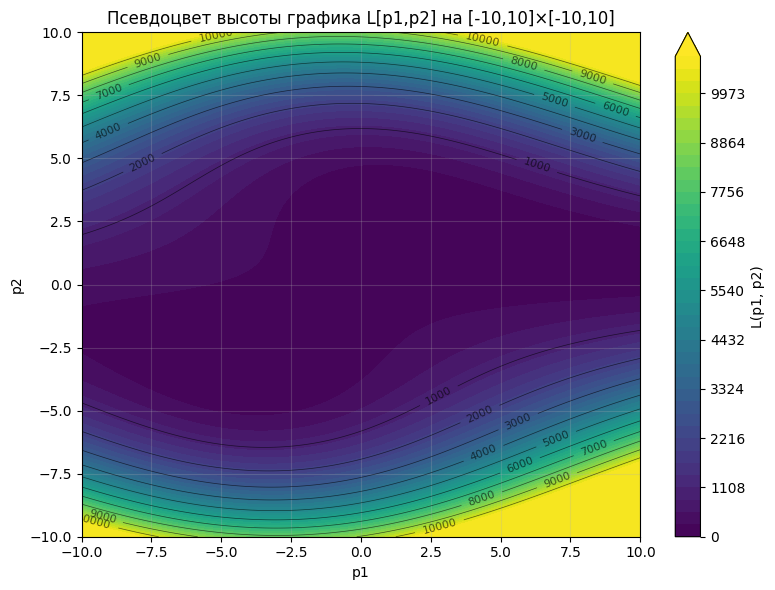

In [123]:
# %% Визуализация L[p1,p2] псевдоцветом и (опционально) в 3D
import numpy as np
import matplotlib.pyplot as plt

# Определим функцию L(p1, p2)
def L(p1, p2):
    # p1, p2: np.ndarray совместимых размеров
    return (p2*p1 + p2 - 11)**2 + (p1 + p2**2 - 7)**2

# Сетка
p1_min, p1_max = -10.0, 10.0
p2_min, p2_max = -10.0, 10.0
n = 600  # точность сетки; можно уменьшить до 400, если медленно

p1 = np.linspace(p1_min, p1_max, n)
p2 = np.linspace(p2_min, p2_max, n)
P1, P2 = np.meshgrid(p1, p2, indexing="xy")
Z = L(P1, P2)

# Масштаб цветовой шкалы — обрежем «хвосты», чтобы были видны детали
vmax = np.percentile(Z, 95)  # можно 90–98 в зависимости от желаемого контраста

plt.figure(figsize=(8,6))
# levels — адаптивные уровни для гладкого градиента
levels = np.linspace(Z.min(), vmax, 40)
cf = plt.contourf(P1, P2, np.clip(Z, Z.min(), vmax), levels=levels, extend="max")
# Добавим тоновые линии поверх
cs = plt.contour(P1, P2, np.clip(Z, Z.min(), vmax), levels=10, colors="k", linewidths=0.5, alpha=0.6)

plt.colorbar(cf, label="L(p1, p2)")
plt.clabel(cs, inline=True, fontsize=8, fmt="%.0f")
plt.xlabel("p1")
plt.ylabel("p2")
plt.title("Псевдоцвет высоты графика L[p1,p2] на [-10,10]×[-10,10]")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


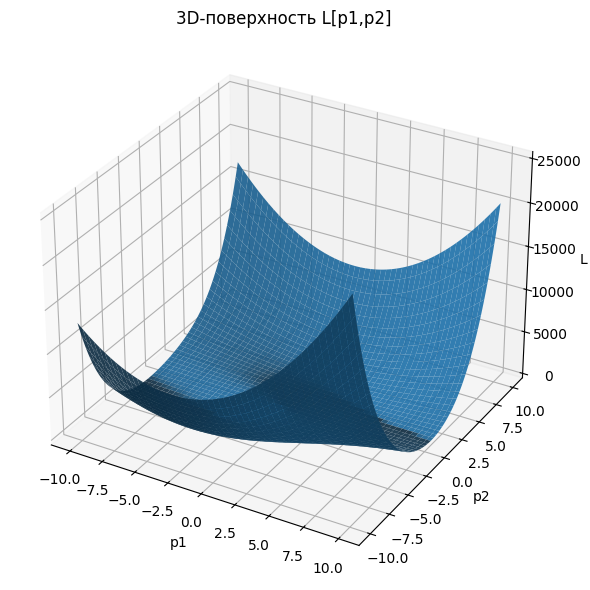

In [124]:
# %% 3D-поверхность (опционально)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (требуется для регистрации 3D-проекций)

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection="3d")

# Для 3D лучше взять более редкую сетку, чтобы отрисовка была шустрой
n3d = 200
p1_3d = np.linspace(p1_min, p1_max, n3d)
p2_3d = np.linspace(p2_min, p2_max, n3d)
P1_3d, P2_3d = np.meshgrid(p1_3d, p2_3d, indexing="xy")
Z3d = L(P1_3d, P2_3d)

ax.plot_surface(P1_3d, P2_3d, Z3d, rstride=4, cstride=4, linewidth=0, antialiased=True, alpha=0.9)
ax.set_xlabel("p1")
ax.set_ylabel("p2")
ax.set_zlabel("L")
ax.set_title("3D-поверхность L[p1,p2]")
plt.tight_layout()
plt.show()
